# 1. Setting up the environment

## 1.1 Checking if the notebook was launched in the correct environment

In [1]:
#prints the available list of environments with asterisk (*) next to the current environment
#need to relaunch jupyter if launched in incorrect environment
!conda env list

# conda environments:
#
base                     C:\Users\Sarthak\anaconda3
prom02_env            *  C:\Users\Sarthak\anaconda3\envs\prom02_env
prom02_prot              C:\Users\Sarthak\anaconda3\envs\prom02_prot



## 1.2 Installing the required packages in the environment

In [2]:
#prints the list of installed packages in the environment
#useful for checking versions and confirming if the packages have successfully installed
!conda list

# packages in environment at C:\Users\Sarthak\anaconda3\envs\prom02_env:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                     eigen  
absl-py                   0.13.0           py38haa95532_0  
aiohttp                   3.7.4            py38h2bbff1b_1  
argon2-cffi               20.1.0           py38h2bbff1b_1  
astor                     0.8.1            py38haa95532_0  
astunparse                1.6.3                      py_0  
async-timeout             3.0.1            py38haa95532_0  
async_generator           1.10               pyhd3eb1b0_0  
attrs                     21.2.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    4.0.0              pyhd3eb1b0_0  
blinker                   1.4              py38haa95532_0  
blosc                     1.21.0               h19a0ad4_0  
bottleneck        

In [3]:
#installing the required packages

import sys
!conda install --yes --prefix {sys.prefix} numpy
!conda install --yes --prefix {sys.prefix} pandas
!conda install --yes --prefix {sys.prefix} matplotlib
!conda install --yes --prefix {sys.prefix} tensorflow
!conda install --yes --prefix {sys.prefix} opencv
!conda install --yes --prefix {sys.prefix} pickle5

## 1.3 Importing the installed packages in the environment

In [58]:
import os #module allowing interaction with the file system
import glob #module for matching pathnames to a specified pattern

import numpy as np #module for added support to large, multi-dimensional arrays
import pandas as pd #module for data manipulation and analysis 
import matplotlib.pyplot as plt #library for creating visualizations

import cv2 #real-time optimized Computer Vision library
import tensorflow as tf #library for training deep neural networks

import time #module to handle time-related tasks such as model training time etc.

import pickle #module for exporting the model

In [5]:
#checking version for tensorflow
print(tf.__version__)

2.3.0


In [6]:
#seting the backend of matplotlib to the 'inline' backend, so the plots are shown in the notebook
%matplotlib inline

# 2. Declaring variables, constants for paths and regex patterns

In [7]:
RAW_DIR = 'MRL_DS_RAW' #directory from where the images for each subject (37 in total) is obtained
CAT_DIR = 'MRL_DS_CAT' #directory where the images are categorised by state i.e., open or closed
SUB_DIR = 'PART_' #sub-directory where files are stored for different datasets

OPEN_DIR = 'OPEN_EYES' #directory where images for open-state for subjects are kept
CLOSED_DIR = 'CLOSED_EYES' #directory where images for closed-state for subjects are kept

IMG_DEF_SIZE = 80 #default size for images

In [95]:
#default batch sizes and epochs
PART_DS_BS =  256
PART_DS_EP = 500

RAW_DS_BS = 5120
RAW_DS_EP = 300

In [9]:
per_subject_regex = 's00??' #regex entry to look into each subject folder
open_eye_regex = '*_?_?_1_?_?_*.png' #regex pattern for open eye-state files
closed_eye_regex = '*_?_?_0_?_?_*.png' #regex pattern for closed eye-state files

In [10]:
#paths for processing files
per_subject_path = f'{RAW_DIR}\\{per_subject_regex}\\'
per_dataset_path = f'{CAT_DIR}\\{SUB_DIR}'

closed_files_path = f'{per_subject_path}\\{closed_eye_regex}'
open_files_path = f'{per_subject_path}\\{open_eye_regex}'

# 3. Defining functions for miscellaneous operations

## 3.1 Function to load the dataset(s) for training

In [11]:
def load_dataset(image_label, path, image_size):
    dataset = []
    
    #allocating files to either closed or open state
    for eye_state in image_label:
        #joining file path with eye state (sub-directory)
        file_path = os.path.join(f'{path}', eye_state)
        #storing eye-state information to use as label
        class_num = image_label.index(eye_state)
        
        #looping through all images in the path
        for image in os.listdir(file_path):
            try:
                #reading the image in grayscale
                image_array = cv2.imread(os.path.join(file_path, image), cv2.IMREAD_GRAYSCALE)
                #converting back to RGB format
                image_back2rgb = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
                #resizing the image to get optimal results
                image_resized = cv2.resize(image_back2rgb, (image_size, image_size))
                #lastly, append to an array
                dataset.append([image_resized, class_num])
            except Exception as e:
                pass
    
    #adding column names and coverting the array to dataframe for easy use
    dataset = pd.DataFrame(dataset,columns=['image','label'],index = None)
    return dataset

## 3.2 Function to split the dataset into training and testing

In [12]:
def split_dataset(dataset):
    #splitting the dataset into training i.e., 70% and testing data i.e., 30%
    training_dataset = dataset.sample(frac=0.7, random_state=25)
    testing_dataset = dataset.drop(training_dataset.index)

    return training_dataset, testing_dataset

## 3.3 Function to split the training and testing datasets into X_train, y_train and X_test, y_test

In [13]:
def split_xy(dataset):
    X = []
    y = []

    #splitting training/testing datasets again into X_train/X_test and y_train/y_test respectively
    for index, row in dataset.iterrows():
        X.append(row["image"])
        y.append(row["label"])

    #normalizing image inputs
    X = np.array(X, dtype='float')
    X = X/255.0

    y = np.array(y)
            
    return X, y

## 3.4 Function to train the CNN model

In [109]:
def train_model(callbacks, xtrain, ytrain, xtest, ytest, batchsize, epochs):
    #storing model training start time
    start_time = time.time()
    
    #CNN model initialisation
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    #fitting training data in the model
    history = model.fit(xtrain, ytrain, batch_size=batchsize, epochs=epochs, callbacks=[callbacks], validation_data=(xtest, ytest))

    #calculating elapsed time in seconds since the start of training process
    elapsed_time = time.time() - start_time
    
    return model, history, round(elapsed_time), time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

# 4. Preparing training and testing data

## 4.1 Getting the path for random part-datasets

In [15]:
#gets all the sub-directories matching the pattern specified i.e., ending in 'PART_'
sub_dir_list = glob.glob(f'{per_dataset_path}*')

In [16]:
#verifying all the paths
print(sub_dir_list)

['MRL_DS_CAT\\PART_1', 'MRL_DS_CAT\\PART_2', 'MRL_DS_CAT\\PART_3']


## 4.2 Loading the datasets

In [17]:
#defining classes for training data i.e., eye-state feature
classes = [f'{CLOSED_DIR}', f'{OPEN_DIR}']
print(classes)

['CLOSED_EYES', 'OPEN_EYES']


### 4.2.1 Loading the random part datasets

In [18]:
#loading all the images in training datasets i.e., PART_1, PART_2, PART_3 etc.
dataset_part1 = load_dataset(classes, sub_dir_list[0], IMG_DEF_SIZE)
dataset_part2 = load_dataset(classes, sub_dir_list[1], IMG_DEF_SIZE)
dataset_part3 = load_dataset(classes, sub_dir_list[2], IMG_DEF_SIZE)

### 4.2.2 Loading the entire dataset

In [19]:
#loading all files in the dataset
all_files = []
for filename in glob.glob(f'{closed_files_path}'):
    all_files.append([filename, CLOSED_DIR])
    
for filename in glob.glob(f'{open_files_path}'):
    all_files.append([filename, OPEN_DIR])

In [20]:
#checking if all files are loaded
print('Number of files loaded for dataset-4 are: '+str(len(all_files)))

Number of files loaded for dataset-4 are: 84898


In [21]:
#organising the dataset with all the samples i.e., 89.5K
dataset_part4 = []

for file, label in all_files:
    file_path = file
    class_num = classes.index(label)
    try:
        #reading the image in grayscale
        image_array = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        #converting back to RGB
        image_back2rgb = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        #resizing image size
        image_resized = cv2.resize(image_back2rgb, (IMG_DEF_SIZE, IMG_DEF_SIZE))
        dataset_part4.append([image_resized, class_num])
    except Exception as e:
        pass

dataset_part4 = pd.DataFrame(dataset_part4, columns=['image','label'],index = None)

In [22]:
#checking the count for images in datasets
print('Number of images in dataset-1 are: '+str(len(dataset_part1)))
print('Number of images in dataset-2 are: '+str(len(dataset_part2)))
print('Number of images in dataset-3 are: '+str(len(dataset_part3)))

print('Number of images in dataset-4 are: '+str(len(dataset_part4)))

Number of images in dataset-1 are: 2055
Number of images in dataset-2 are: 2055
Number of images in dataset-3 are: 2055
Number of images in dataset-4 are: 84898


## 4.3 Splitting the datasets into training and testing

In [23]:
#splitting all the dataset into training i.e., 70% and testing data i.e., 30%
training_dataset_part1, testing_dataset_part1 = split_dataset(dataset_part1)
training_dataset_part2, testing_dataset_part2 = split_dataset(dataset_part2)
training_dataset_part3, testing_dataset_part3 = split_dataset(dataset_part3)

training_dataset_part4, testing_dataset_part4 = split_dataset(dataset_part4)

In [24]:
#printing the count for train and test split for each dataset
print(f'In dataset 1, training samples are: {training_dataset_part1.shape[0]} and testing samples are: {testing_dataset_part1.shape[0]}')
print(f'In dataset 2, training samples are: {training_dataset_part2.shape[0]} and testing samples are: {testing_dataset_part2.shape[0]}')
print(f'In dataset 3, training samples are: {training_dataset_part3.shape[0]} and testing samples are: {testing_dataset_part3.shape[0]}')

print(f'In dataset 4, training samples are: {training_dataset_part4.shape[0]} and testing samples are: {testing_dataset_part4.shape[0]}')

In dataset 1, training samples are: 1438 and testing samples are: 617
In dataset 2, training samples are: 1438 and testing samples are: 617
In dataset 3, training samples are: 1438 and testing samples are: 617
In dataset 4, training samples are: 59429 and testing samples are: 25469


## 4.4 Splitting further into X_train, y_train, X_test and y_test

In [25]:
#preparing X_train and y_train from the training data
X_train_part1, y_train_part1 = split_xy(training_dataset_part1)
X_train_part2, y_train_part2 = split_xy(training_dataset_part2)
X_train_part3, y_train_part3 = split_xy(training_dataset_part3)

X_train_part4, y_train_part4 = split_xy(training_dataset_part4)

#preparing X_test and y_test from the testing data
X_test_part1, y_test_part1 = split_xy(testing_dataset_part1)
X_test_part2, y_test_part2 = split_xy(testing_dataset_part2)
X_test_part3, y_test_part3 = split_xy(testing_dataset_part3)

X_test_part4, y_test_part4 = split_xy(testing_dataset_part4)

# 5. Training the model with the dataset(s)

In [26]:
#implementing callback approach
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [27]:
#training models and getting training time - part datasets 1-3
cnn_model_part1, cnn_hist_part1, cnn_time_part1, cnn_stime_part1 = train_model(callbacks, X_train_part1, y_train_part1, X_test_part1, y_test_part1, PART_DS_BS, PART_DS_EP)
cnn_model_part2, cnn_hist_part2, cnn_time_part2, cnn_stime_part2 = train_model(callbacks, X_train_part2, y_train_part2, X_test_part2, y_test_part2, PART_DS_BS, PART_DS_EP)
cnn_model_part3, cnn_hist_part3, cnn_time_part3, cnn_stime_part3 = train_model(callbacks, X_train_part3, y_train_part3, X_test_part3, y_test_part3, PART_DS_BS, PART_DS_EP)

Epoch 1/500
6/6 [==============================] - 3s 576ms/step - loss: 13.7925 - accuracy: 0.4047 - val_loss: 30.0495 - val_accuracy: 0.5073
Epoch 2/500
6/6 [==============================] - 3s 526ms/step - loss: 18.9374 - accuracy: 0.5195 - val_loss: 25.7660 - val_accuracy: 0.4927
Epoch 3/500
6/6 [==============================] - 3s 518ms/step - loss: 12.9804 - accuracy: 0.5160 - val_loss: 9.5375 - val_accuracy: 0.5073
Epoch 4/500
6/6 [==============================] - 3s 567ms/step - loss: 6.0746 - accuracy: 0.5264 - val_loss: 1.9366 - val_accuracy: 0.6532
Epoch 5/500
6/6 [==============================] - 3s 535ms/step - loss: 3.2337 - accuracy: 0.6001 - val_loss: 1.5481 - val_accuracy: 0.6872
Epoch 6/500
6/6 [==============================] - 3s 491ms/step - loss: 1.4160 - accuracy: 0.7350 - val_loss: 1.7050 - val_accuracy: 0.6872
Epoch 7/500
6/6 [==============================] - 3s 515ms/step - loss: 1.3099 - accuracy: 0.7559 - val_loss: 0.7889 - val_accuracy: 0.8071
Epoch 8/

Epoch 59/500
6/6 [==============================] - 3s 488ms/step - loss: 0.3425 - accuracy: 0.8797 - val_loss: 0.3274 - val_accuracy: 0.8882
Epoch 60/500
6/6 [==============================] - 3s 471ms/step - loss: 0.3474 - accuracy: 0.8783 - val_loss: 0.3529 - val_accuracy: 0.8768
Epoch 61/500
6/6 [==============================] - 3s 514ms/step - loss: 0.3141 - accuracy: 0.8936 - val_loss: 0.3614 - val_accuracy: 0.8622
Epoch 62/500
6/6 [==============================] - 3s 571ms/step - loss: 0.4195 - accuracy: 0.8324 - val_loss: 0.3526 - val_accuracy: 0.8687
Epoch 63/500
6/6 [==============================] - 3s 470ms/step - loss: 0.3724 - accuracy: 0.8637 - val_loss: 0.5273 - val_accuracy: 0.7861
Epoch 64/500
6/6 [==============================] - 3s 498ms/step - loss: 0.4376 - accuracy: 0.8303 - val_loss: 0.4483 - val_accuracy: 0.8136
Epoch 65/500
6/6 [==============================] - 3s 511ms/step - loss: 0.4621 - accuracy: 0.8234 - val_loss: 0.4149 - val_accuracy: 0.8314
Epoch 

6/6 [==============================] - 3s 489ms/step - loss: 0.3212 - accuracy: 0.8901 - val_loss: 0.3400 - val_accuracy: 0.8720
Epoch 117/500
6/6 [==============================] - 3s 480ms/step - loss: 0.3258 - accuracy: 0.8846 - val_loss: 0.7534 - val_accuracy: 0.7310
Epoch 118/500
6/6 [==============================] - 3s 486ms/step - loss: 0.3670 - accuracy: 0.8672 - val_loss: 0.3883 - val_accuracy: 0.8460
Epoch 119/500
6/6 [==============================] - 3s 474ms/step - loss: 0.3922 - accuracy: 0.8484 - val_loss: 0.4887 - val_accuracy: 0.7942
Epoch 120/500
6/6 [==============================] - 3s 491ms/step - loss: 0.4819 - accuracy: 0.8241 - val_loss: 0.3512 - val_accuracy: 0.8687
Epoch 121/500
6/6 [==============================] - 3s 488ms/step - loss: 0.4180 - accuracy: 0.8477 - val_loss: 0.5819 - val_accuracy: 0.7763
Epoch 122/500
6/6 [==============================] - 3s 480ms/step - loss: 0.3436 - accuracy: 0.8686 - val_loss: 0.3053 - val_accuracy: 0.8995
Epoch 123/500

6/6 [==============================] - 3s 466ms/step - loss: 0.3290 - accuracy: 0.8665 - val_loss: 0.2903 - val_accuracy: 0.8963
Epoch 174/500
6/6 [==============================] - 3s 468ms/step - loss: 0.2451 - accuracy: 0.9117 - val_loss: 0.2776 - val_accuracy: 0.9011
Epoch 175/500
6/6 [==============================] - 3s 487ms/step - loss: 0.2352 - accuracy: 0.9193 - val_loss: 0.2822 - val_accuracy: 0.8995
Epoch 176/500
6/6 [==============================] - 3s 490ms/step - loss: 0.2259 - accuracy: 0.9179 - val_loss: 0.2774 - val_accuracy: 0.8979
Epoch 177/500
6/6 [==============================] - 3s 480ms/step - loss: 0.2885 - accuracy: 0.8964 - val_loss: 0.3288 - val_accuracy: 0.8639
Epoch 178/500
6/6 [==============================] - 3s 471ms/step - loss: 0.3475 - accuracy: 0.8581 - val_loss: 0.5054 - val_accuracy: 0.7909
Epoch 179/500
6/6 [==============================] - 3s 484ms/step - loss: 0.3045 - accuracy: 0.8679 - val_loss: 0.2816 - val_accuracy: 0.9044
Epoch 180/500

6/6 [==============================] - 3s 505ms/step - loss: 0.2183 - accuracy: 0.9249 - val_loss: 0.2675 - val_accuracy: 0.9109
Epoch 231/500
6/6 [==============================] - 3s 478ms/step - loss: 0.2090 - accuracy: 0.9318 - val_loss: 0.2673 - val_accuracy: 0.9125
Epoch 232/500
6/6 [==============================] - 3s 481ms/step - loss: 0.2180 - accuracy: 0.9235 - val_loss: 0.2621 - val_accuracy: 0.9044
Epoch 233/500
6/6 [==============================] - 3s 458ms/step - loss: 0.2079 - accuracy: 0.9270 - val_loss: 0.2713 - val_accuracy: 0.9060
Epoch 234/500
6/6 [==============================] - 3s 498ms/step - loss: 0.2002 - accuracy: 0.9332 - val_loss: 0.2704 - val_accuracy: 0.9044
Epoch 235/500
6/6 [==============================] - 3s 488ms/step - loss: 0.1974 - accuracy: 0.9353 - val_loss: 0.2678 - val_accuracy: 0.8979
Epoch 236/500
6/6 [==============================] - 3s 465ms/step - loss: 0.2171 - accuracy: 0.9228 - val_loss: 0.3522 - val_accuracy: 0.8525
Epoch 237/500

6/6 [==============================] - 3s 501ms/step - loss: 0.2027 - accuracy: 0.9270 - val_loss: 0.3206 - val_accuracy: 0.8833
Epoch 288/500
6/6 [==============================] - 3s 479ms/step - loss: 0.2345 - accuracy: 0.9145 - val_loss: 0.5072 - val_accuracy: 0.8023
Epoch 289/500
6/6 [==============================] - 3s 479ms/step - loss: 0.2358 - accuracy: 0.9040 - val_loss: 0.3103 - val_accuracy: 0.8752
Epoch 290/500
6/6 [==============================] - 3s 476ms/step - loss: 0.1903 - accuracy: 0.9305 - val_loss: 0.2519 - val_accuracy: 0.9206
Epoch 291/500
6/6 [==============================] - 3s 480ms/step - loss: 0.1804 - accuracy: 0.9430 - val_loss: 0.2439 - val_accuracy: 0.9141
Epoch 292/500
6/6 [==============================] - 3s 514ms/step - loss: 0.1808 - accuracy: 0.9353 - val_loss: 0.2707 - val_accuracy: 0.9141
Epoch 293/500
6/6 [==============================] - 3s 457ms/step - loss: 0.1959 - accuracy: 0.9277 - val_loss: 0.2796 - val_accuracy: 0.8995
Epoch 294/500

Epoch 31/500
6/6 [==============================] - 3s 445ms/step - loss: 0.4088 - accuracy: 0.8428 - val_loss: 0.5546 - val_accuracy: 0.7958
Epoch 32/500
6/6 [==============================] - 3s 443ms/step - loss: 0.3715 - accuracy: 0.8679 - val_loss: 0.4351 - val_accuracy: 0.8655
Epoch 33/500
6/6 [==============================] - 3s 453ms/step - loss: 0.3624 - accuracy: 0.8727 - val_loss: 0.5094 - val_accuracy: 0.7844
Epoch 34/500
6/6 [==============================] - 3s 448ms/step - loss: 0.3855 - accuracy: 0.8561 - val_loss: 0.8274 - val_accuracy: 0.6629
Epoch 35/500
6/6 [==============================] - 3s 449ms/step - loss: 0.4893 - accuracy: 0.8039 - val_loss: 0.6410 - val_accuracy: 0.7342
Epoch 36/500
6/6 [==============================] - 3s 455ms/step - loss: 0.4736 - accuracy: 0.7976 - val_loss: 0.4093 - val_accuracy: 0.8655
Epoch 37/500
6/6 [==============================] - 3s 459ms/step - loss: 0.3741 - accuracy: 0.8762 - val_loss: 0.4143 - val_accuracy: 0.8622
Epoch 

Epoch 89/500
6/6 [==============================] - 3s 441ms/step - loss: 0.2893 - accuracy: 0.9096 - val_loss: 0.4155 - val_accuracy: 0.8525
Epoch 90/500
6/6 [==============================] - 3s 460ms/step - loss: 0.2942 - accuracy: 0.8957 - val_loss: 0.4310 - val_accuracy: 0.8314
Epoch 91/500
6/6 [==============================] - 3s 454ms/step - loss: 0.3601 - accuracy: 0.8741 - val_loss: 0.5124 - val_accuracy: 0.7861
Epoch 92/500
6/6 [==============================] - 3s 443ms/step - loss: 0.3253 - accuracy: 0.8811 - val_loss: 0.4110 - val_accuracy: 0.8606
Epoch 93/500
6/6 [==============================] - 3s 461ms/step - loss: 0.3304 - accuracy: 0.8818 - val_loss: 0.5573 - val_accuracy: 0.7780
Epoch 94/500
6/6 [==============================] - 3s 455ms/step - loss: 0.4099 - accuracy: 0.8449 - val_loss: 1.0725 - val_accuracy: 0.6029
Epoch 95/500
6/6 [==============================] - 3s 474ms/step - loss: 0.4917 - accuracy: 0.8088 - val_loss: 0.6699 - val_accuracy: 0.7439
Epoch 

6/6 [==============================] - 3s 446ms/step - loss: 0.3307 - accuracy: 0.8783 - val_loss: 0.4152 - val_accuracy: 0.8720
Epoch 147/500
6/6 [==============================] - 3s 456ms/step - loss: 0.2637 - accuracy: 0.9075 - val_loss: 0.4207 - val_accuracy: 0.8768
Epoch 148/500
6/6 [==============================] - 3s 450ms/step - loss: 0.2863 - accuracy: 0.9040 - val_loss: 0.5132 - val_accuracy: 0.8395
Epoch 149/500
6/6 [==============================] - 3s 465ms/step - loss: 0.3511 - accuracy: 0.8672 - val_loss: 0.4431 - val_accuracy: 0.8655
Epoch 150/500
6/6 [==============================] - 3s 461ms/step - loss: 0.3077 - accuracy: 0.8790 - val_loss: 0.4034 - val_accuracy: 0.8687
Epoch 151/500
6/6 [==============================] - 3s 449ms/step - loss: 0.2742 - accuracy: 0.9082 - val_loss: 0.4727 - val_accuracy: 0.8574
Epoch 152/500
6/6 [==============================] - 3s 462ms/step - loss: 0.3604 - accuracy: 0.8609 - val_loss: 0.5674 - val_accuracy: 0.8104
Epoch 153/500

6/6 [==============================] - 3s 456ms/step - loss: 0.3753 - accuracy: 0.8540 - val_loss: 0.4987 - val_accuracy: 0.8023
Epoch 204/500
6/6 [==============================] - 3s 440ms/step - loss: 0.2867 - accuracy: 0.8971 - val_loss: 0.4742 - val_accuracy: 0.8444
Epoch 205/500
6/6 [==============================] - 3s 459ms/step - loss: 0.3911 - accuracy: 0.8491 - val_loss: 0.3965 - val_accuracy: 0.8801
Epoch 206/500
6/6 [==============================] - 3s 451ms/step - loss: 0.2542 - accuracy: 0.9068 - val_loss: 0.4553 - val_accuracy: 0.8622
Epoch 207/500
6/6 [==============================] - 3s 455ms/step - loss: 0.2773 - accuracy: 0.8992 - val_loss: 0.3840 - val_accuracy: 0.8768
Epoch 208/500
6/6 [==============================] - 3s 448ms/step - loss: 0.2644 - accuracy: 0.9082 - val_loss: 0.3828 - val_accuracy: 0.8736
Epoch 209/500
6/6 [==============================] - 3s 440ms/step - loss: 0.3319 - accuracy: 0.8762 - val_loss: 0.4977 - val_accuracy: 0.8395
Epoch 210/500

6/6 [==============================] - 3s 443ms/step - loss: 0.2996 - accuracy: 0.8853 - val_loss: 0.3690 - val_accuracy: 0.8801
Epoch 261/500
6/6 [==============================] - 3s 478ms/step - loss: 0.2356 - accuracy: 0.9110 - val_loss: 0.3715 - val_accuracy: 0.8720
Epoch 262/500
6/6 [==============================] - 3s 459ms/step - loss: 0.2436 - accuracy: 0.9089 - val_loss: 0.4171 - val_accuracy: 0.8395
Epoch 263/500
6/6 [==============================] - 3s 452ms/step - loss: 0.2296 - accuracy: 0.9214 - val_loss: 0.5363 - val_accuracy: 0.8071
Epoch 264/500
6/6 [==============================] - 3s 482ms/step - loss: 0.2979 - accuracy: 0.8866 - val_loss: 0.3920 - val_accuracy: 0.8558
Epoch 265/500
6/6 [==============================] - 3s 484ms/step - loss: 0.2357 - accuracy: 0.9186 - val_loss: 0.3889 - val_accuracy: 0.8606
Epoch 266/500
6/6 [==============================] - 3s 470ms/step - loss: 0.2251 - accuracy: 0.9193 - val_loss: 0.4476 - val_accuracy: 0.8493
Epoch 267/500

6/6 [==============================] - 3s 466ms/step - loss: 0.1956 - accuracy: 0.9305 - val_loss: 0.3357 - val_accuracy: 0.8801
Epoch 318/500
6/6 [==============================] - 3s 471ms/step - loss: 0.1825 - accuracy: 0.9416 - val_loss: 0.3093 - val_accuracy: 0.9011
Epoch 319/500
6/6 [==============================] - 3s 456ms/step - loss: 0.1999 - accuracy: 0.9284 - val_loss: 0.3743 - val_accuracy: 0.8703
Epoch 320/500
6/6 [==============================] - 3s 479ms/step - loss: 0.2217 - accuracy: 0.9179 - val_loss: 0.5764 - val_accuracy: 0.7536
Epoch 321/500
6/6 [==============================] - 3s 461ms/step - loss: 0.2676 - accuracy: 0.8943 - val_loss: 0.3572 - val_accuracy: 0.8817
Epoch 322/500
6/6 [==============================] - 3s 466ms/step - loss: 0.2512 - accuracy: 0.8985 - val_loss: 0.3845 - val_accuracy: 0.8655
Epoch 323/500
6/6 [==============================] - 3s 472ms/step - loss: 0.2366 - accuracy: 0.9138 - val_loss: 0.3912 - val_accuracy: 0.8460
Epoch 324/500

Epoch 34/500
6/6 [==============================] - 3s 441ms/step - loss: 0.5793 - accuracy: 0.7803 - val_loss: 0.3764 - val_accuracy: 0.8606
Epoch 35/500
6/6 [==============================] - 3s 457ms/step - loss: 0.3805 - accuracy: 0.8609 - val_loss: 0.3836 - val_accuracy: 0.8558
Epoch 36/500
6/6 [==============================] - 3s 444ms/step - loss: 0.4880 - accuracy: 0.8108 - val_loss: 0.4127 - val_accuracy: 0.8185
Epoch 37/500
6/6 [==============================] - 3s 437ms/step - loss: 0.6483 - accuracy: 0.7531 - val_loss: 0.3665 - val_accuracy: 0.8622
Epoch 38/500
6/6 [==============================] - 3s 467ms/step - loss: 0.4990 - accuracy: 0.8115 - val_loss: 0.5049 - val_accuracy: 0.8201
Epoch 39/500
6/6 [==============================] - 3s 429ms/step - loss: 0.4529 - accuracy: 0.8199 - val_loss: 0.5512 - val_accuracy: 0.7990
Epoch 40/500
6/6 [==============================] - 3s 435ms/step - loss: 0.4520 - accuracy: 0.8366 - val_loss: 0.3767 - val_accuracy: 0.8671
Epoch 

Epoch 92/500
6/6 [==============================] - 3s 436ms/step - loss: 0.3921 - accuracy: 0.8665 - val_loss: 0.3609 - val_accuracy: 0.8703
Epoch 93/500
6/6 [==============================] - 3s 447ms/step - loss: 0.3492 - accuracy: 0.8832 - val_loss: 0.4113 - val_accuracy: 0.8622
Epoch 94/500
6/6 [==============================] - 3s 443ms/step - loss: 0.3372 - accuracy: 0.8915 - val_loss: 0.3801 - val_accuracy: 0.8671
Epoch 95/500
6/6 [==============================] - 3s 457ms/step - loss: 0.3232 - accuracy: 0.8943 - val_loss: 0.3729 - val_accuracy: 0.8687
Epoch 96/500
6/6 [==============================] - 3s 445ms/step - loss: 0.3763 - accuracy: 0.8658 - val_loss: 0.3586 - val_accuracy: 0.8622
Epoch 97/500
6/6 [==============================] - 3s 439ms/step - loss: 0.3498 - accuracy: 0.8762 - val_loss: 0.4768 - val_accuracy: 0.8088
Epoch 98/500
6/6 [==============================] - 3s 451ms/step - loss: 0.3543 - accuracy: 0.8707 - val_loss: 0.3674 - val_accuracy: 0.8606
Epoch 

6/6 [==============================] - 3s 439ms/step - loss: 0.2994 - accuracy: 0.8985 - val_loss: 0.3368 - val_accuracy: 0.8736
Epoch 150/500
6/6 [==============================] - 3s 460ms/step - loss: 0.2603 - accuracy: 0.9124 - val_loss: 0.3369 - val_accuracy: 0.8655
Epoch 151/500
6/6 [==============================] - 3s 454ms/step - loss: 0.2810 - accuracy: 0.9054 - val_loss: 0.3563 - val_accuracy: 0.8525
Epoch 152/500
6/6 [==============================] - 3s 451ms/step - loss: 0.3619 - accuracy: 0.8477 - val_loss: 0.3774 - val_accuracy: 0.8590
Epoch 153/500
6/6 [==============================] - 3s 446ms/step - loss: 0.2733 - accuracy: 0.8978 - val_loss: 0.3366 - val_accuracy: 0.8622
Epoch 154/500
6/6 [==============================] - 3s 455ms/step - loss: 0.2569 - accuracy: 0.9061 - val_loss: 0.4976 - val_accuracy: 0.8233
Epoch 155/500
6/6 [==============================] - 3s 459ms/step - loss: 0.3579 - accuracy: 0.8581 - val_loss: 0.6261 - val_accuracy: 0.7844
Epoch 156/500

6/6 [==============================] - 3s 450ms/step - loss: 0.2455 - accuracy: 0.8985 - val_loss: 0.3609 - val_accuracy: 0.8655
Epoch 207/500
6/6 [==============================] - 3s 442ms/step - loss: 0.2559 - accuracy: 0.8964 - val_loss: 0.3105 - val_accuracy: 0.8882
Epoch 208/500
6/6 [==============================] - 3s 453ms/step - loss: 0.2171 - accuracy: 0.9152 - val_loss: 0.3084 - val_accuracy: 0.8574
Epoch 209/500
6/6 [==============================] - 3s 442ms/step - loss: 0.2033 - accuracy: 0.9270 - val_loss: 0.3390 - val_accuracy: 0.8574
Epoch 210/500
6/6 [==============================] - 3s 445ms/step - loss: 0.2358 - accuracy: 0.9117 - val_loss: 0.3007 - val_accuracy: 0.8801
Epoch 211/500
6/6 [==============================] - 3s 447ms/step - loss: 0.2136 - accuracy: 0.9221 - val_loss: 0.3031 - val_accuracy: 0.8833
Epoch 212/500
6/6 [==============================] - 3s 439ms/step - loss: 0.2117 - accuracy: 0.9179 - val_loss: 0.3376 - val_accuracy: 0.8606
Epoch 213/500

6/6 [==============================] - 3s 452ms/step - loss: 0.1842 - accuracy: 0.9312 - val_loss: 0.2740 - val_accuracy: 0.8801
Epoch 264/500
6/6 [==============================] - 3s 441ms/step - loss: 0.1883 - accuracy: 0.9339 - val_loss: 0.2959 - val_accuracy: 0.8752
Epoch 265/500
6/6 [==============================] - 3s 446ms/step - loss: 0.1688 - accuracy: 0.9409 - val_loss: 0.3112 - val_accuracy: 0.8882
Epoch 266/500
6/6 [==============================] - 3s 454ms/step - loss: 0.1842 - accuracy: 0.9277 - val_loss: 0.2812 - val_accuracy: 0.8768
Epoch 267/500
6/6 [==============================] - 3s 451ms/step - loss: 0.2001 - accuracy: 0.9221 - val_loss: 0.2831 - val_accuracy: 0.8720
Epoch 268/500
6/6 [==============================] - 3s 446ms/step - loss: 0.1894 - accuracy: 0.9277 - val_loss: 0.2774 - val_accuracy: 0.8947
Epoch 269/500
6/6 [==============================] - 3s 465ms/step - loss: 0.1683 - accuracy: 0.9360 - val_loss: 0.3057 - val_accuracy: 0.8687
Epoch 270/500

In [28]:
#training models and getting training time - complete dataset
cnn_model_part4, cnn_hist_part4, cnn_time_part4, cnn_stime_part4 = train_model(callbacks, X_train_part4, y_train_part4, X_test_part4, y_test_part4, RAW_DS_BS, RAW_DS_EP)

Epoch 1/300
12/12 [==============================] - 89s 7s/step - loss: 17.7863 - accuracy: 0.4603 - val_loss: 22.2089 - val_accuracy: 0.4940
Epoch 2/300
12/12 [==============================] - 82s 7s/step - loss: 11.9181 - accuracy: 0.5396 - val_loss: 3.6494 - val_accuracy: 0.5609
Epoch 3/300
12/12 [==============================] - 80s 7s/step - loss: 4.0179 - accuracy: 0.6051 - val_loss: 3.1510 - val_accuracy: 0.6045
Epoch 4/300
12/12 [==============================] - 81s 7s/step - loss: 1.6603 - accuracy: 0.7353 - val_loss: 1.3661 - val_accuracy: 0.7530
Epoch 5/300
12/12 [==============================] - 80s 7s/step - loss: 1.0279 - accuracy: 0.8077 - val_loss: 0.8601 - val_accuracy: 0.8290
Epoch 6/300
12/12 [==============================] - 80s 7s/step - loss: 0.8077 - accuracy: 0.8453 - val_loss: 0.6876 - val_accuracy: 0.8607
Epoch 7/300
12/12 [==============================] - 80s 7s/step - loss: 0.6805 - accuracy: 0.8591 - val_loss: 0.6273 - val_accuracy: 0.8638
Epoch 8/30

Epoch 59/300
12/12 [==============================] - 80s 7s/step - loss: 0.3738 - accuracy: 0.8747 - val_loss: 0.4032 - val_accuracy: 0.8499
Epoch 60/300
12/12 [==============================] - 78s 6s/step - loss: 0.3305 - accuracy: 0.8898 - val_loss: 0.3071 - val_accuracy: 0.8958
Epoch 61/300
12/12 [==============================] - 80s 7s/step - loss: 0.2886 - accuracy: 0.9043 - val_loss: 0.3759 - val_accuracy: 0.8663
Epoch 62/300
12/12 [==============================] - 83s 7s/step - loss: 0.3014 - accuracy: 0.8958 - val_loss: 0.2782 - val_accuracy: 0.9058
Epoch 63/300
12/12 [==============================] - 82s 7s/step - loss: 0.2780 - accuracy: 0.9062 - val_loss: 0.3401 - val_accuracy: 0.8775
Epoch 64/300
12/12 [==============================] - 80s 7s/step - loss: 0.3193 - accuracy: 0.8845 - val_loss: 0.2802 - val_accuracy: 0.9056
Epoch 65/300
12/12 [==============================] - 80s 7s/step - loss: 0.2713 - accuracy: 0.9094 - val_loss: 0.2736 - val_accuracy: 0.9074
Epoch 

12/12 [==============================] - 79s 7s/step - loss: 0.2653 - accuracy: 0.9093 - val_loss: 0.2732 - val_accuracy: 0.9055
Epoch 117/300
12/12 [==============================] - 80s 7s/step - loss: 0.3933 - accuracy: 0.8467 - val_loss: 0.2931 - val_accuracy: 0.8988
Epoch 118/300
12/12 [==============================] - 80s 7s/step - loss: 0.2832 - accuracy: 0.9010 - val_loss: 0.2665 - val_accuracy: 0.9105
Epoch 119/300
12/12 [==============================] - 81s 7s/step - loss: 0.2660 - accuracy: 0.9101 - val_loss: 0.3052 - val_accuracy: 0.8898
Epoch 120/300
12/12 [==============================] - 79s 7s/step - loss: 0.2907 - accuracy: 0.8972 - val_loss: 0.2597 - val_accuracy: 0.9120
Epoch 121/300
12/12 [==============================] - 80s 7s/step - loss: 0.2583 - accuracy: 0.9116 - val_loss: 0.2734 - val_accuracy: 0.9039
Epoch 122/300
12/12 [==============================] - 79s 7s/step - loss: 0.2567 - accuracy: 0.9122 - val_loss: 0.2533 - val_accuracy: 0.9143
Epoch 123/300

12/12 [==============================] - 81s 7s/step - loss: 0.2421 - accuracy: 0.9130 - val_loss: 0.2386 - val_accuracy: 0.9171
Epoch 174/300
12/12 [==============================] - 79s 7s/step - loss: 0.2447 - accuracy: 0.9105 - val_loss: 0.2354 - val_accuracy: 0.9134
Epoch 175/300
12/12 [==============================] - 80s 7s/step - loss: 0.2574 - accuracy: 0.9041 - val_loss: 0.2169 - val_accuracy: 0.9253
Epoch 176/300
12/12 [==============================] - 81s 7s/step - loss: 0.2873 - accuracy: 0.8910 - val_loss: 0.2636 - val_accuracy: 0.9067
Epoch 177/300
12/12 [==============================] - 83s 7s/step - loss: 0.2187 - accuracy: 0.9213 - val_loss: 0.2171 - val_accuracy: 0.9234
Epoch 178/300
12/12 [==============================] - 81s 7s/step - loss: 0.2040 - accuracy: 0.9277 - val_loss: 0.2149 - val_accuracy: 0.9236
Epoch 179/300
12/12 [==============================] - 79s 7s/step - loss: 0.2006 - accuracy: 0.9292 - val_loss: 0.2099 - val_accuracy: 0.9260
Epoch 180/300

12/12 [==============================] - 80s 7s/step - loss: 0.1676 - accuracy: 0.9404 - val_loss: 0.1745 - val_accuracy: 0.9393
Epoch 231/300
12/12 [==============================] - 80s 7s/step - loss: 0.1649 - accuracy: 0.9409 - val_loss: 0.1764 - val_accuracy: 0.9364
Epoch 232/300
12/12 [==============================] - 80s 7s/step - loss: 0.1636 - accuracy: 0.9412 - val_loss: 0.1730 - val_accuracy: 0.9382
Epoch 233/300
12/12 [==============================] - 81s 7s/step - loss: 0.1646 - accuracy: 0.9401 - val_loss: 0.2092 - val_accuracy: 0.9257
Epoch 234/300
12/12 [==============================] - 80s 7s/step - loss: 0.1674 - accuracy: 0.9392 - val_loss: 0.1827 - val_accuracy: 0.9356
Epoch 235/300
12/12 [==============================] - 81s 7s/step - loss: 0.1703 - accuracy: 0.9384 - val_loss: 0.1814 - val_accuracy: 0.9372
Epoch 236/300
12/12 [==============================] - 81s 7s/step - loss: 0.1698 - accuracy: 0.9379 - val_loss: 0.1872 - val_accuracy: 0.9291
Epoch 237/300

## 5.1 Plotting model histories to check for overfitting

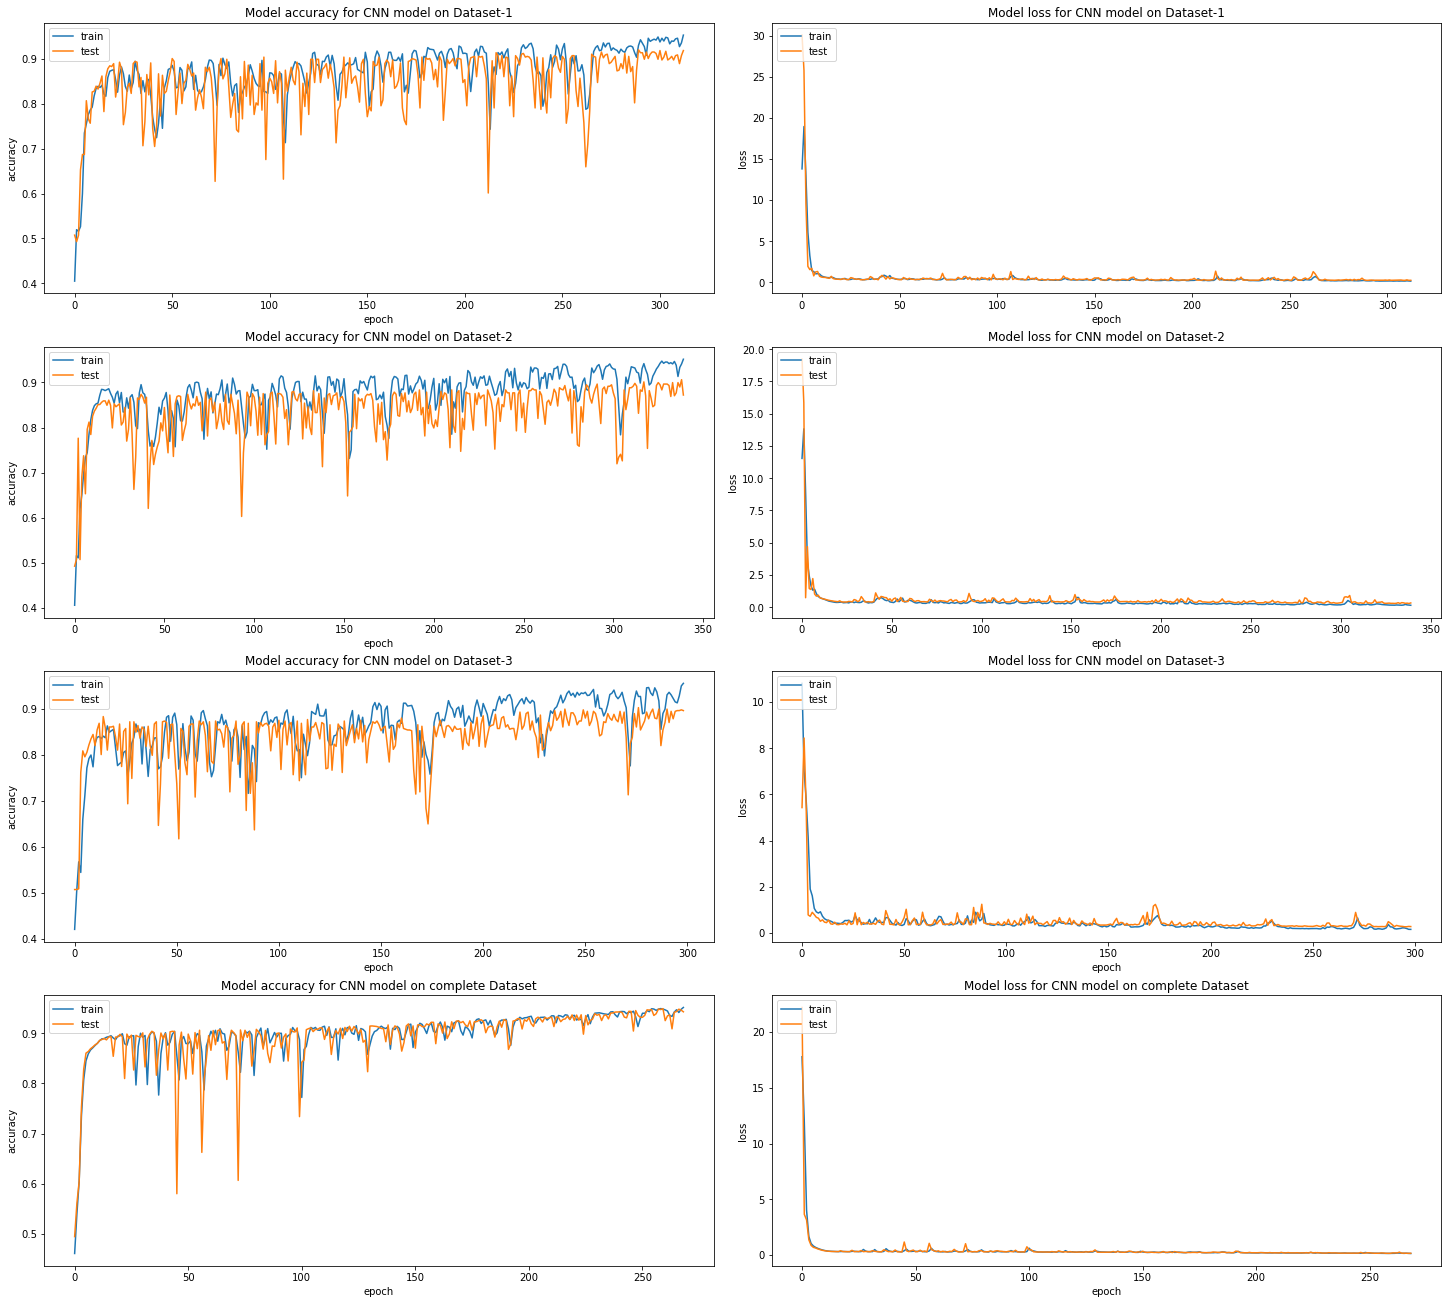

In [29]:
fig, axis = plt.subplots(nrows = 4, ncols = 2, figsize = (20, 18), constrained_layout=True)
  
#plotting accuracy, validation accuracy and loss, validation loss for model on part-dataset1
#summarize history for accuracy
axis[0, 0].plot(cnn_hist_part1.history['accuracy'])
axis[0, 0].plot(cnn_hist_part1.history['val_accuracy'])
axis[0, 0].set_title('Model accuracy for CNN model on Dataset-1')
axis[0, 0].set_ylabel('accuracy')
axis[0, 0].set_xlabel('epoch')
axis[0, 0].legend(['train', 'test'], loc='upper left')

#summarize history for loss
axis[0, 1].plot(cnn_hist_part1.history['loss'])
axis[0, 1].plot(cnn_hist_part1.history['val_loss'])
axis[0, 1].set_title('Model loss for CNN model on Dataset-1')
axis[0, 1].set_ylabel('loss')
axis[0, 1].set_xlabel('epoch')
axis[0, 1].legend(['train', 'test'], loc='upper left')

#plotting accuracy, validation accuracy and loss, validation loss for model on part-dataset2
#summarize history for accuracy
axis[1, 0].plot(cnn_hist_part2.history['accuracy'])
axis[1, 0].plot(cnn_hist_part2.history['val_accuracy'])
axis[1, 0].set_title('Model accuracy for CNN model on Dataset-2')
axis[1, 0].set_ylabel('accuracy')
axis[1, 0].set_xlabel('epoch')
axis[1, 0].legend(['train', 'test'], loc='upper left')

#summarize history for loss
axis[1, 1].plot(cnn_hist_part2.history['loss'])
axis[1, 1].plot(cnn_hist_part2.history['val_loss'])
axis[1, 1].set_title('Model loss for CNN model on Dataset-2')
axis[1, 1].set_ylabel('loss')
axis[1, 1].set_xlabel('epoch')
axis[1, 1].legend(['train', 'test'], loc='upper left')

#plotting accuracy, validation accuracy and loss, validation loss for model on part-dataset3
#summarize history for accuracy
axis[2, 0].plot(cnn_hist_part3.history['accuracy'])
axis[2, 0].plot(cnn_hist_part3.history['val_accuracy'])
axis[2, 0].set_title('Model accuracy for CNN model on Dataset-3')
axis[2, 0].set_ylabel('accuracy')
axis[2, 0].set_xlabel('epoch')
axis[2, 0].legend(['train', 'test'], loc='upper left')

#summarize history for loss
axis[2, 1].plot(cnn_hist_part3.history['loss'])
axis[2, 1].plot(cnn_hist_part3.history['val_loss'])
axis[2, 1].set_title('Model loss for CNN model on Dataset-3')
axis[2, 1].set_ylabel('loss')
axis[2, 1].set_xlabel('epoch')
axis[2, 1].legend(['train', 'test'], loc='upper left')

#plotting accuracy, validation accuracy and loss, validation loss for model on entire dataset
#summarize history for accuracy
axis[3, 0].plot(cnn_hist_part4.history['accuracy'])
axis[3, 0].plot(cnn_hist_part4.history['val_accuracy'])
axis[3, 0].set_title('Model accuracy for CNN model on complete Dataset')
axis[3, 0].set_ylabel('accuracy')
axis[3, 0].set_xlabel('epoch')
axis[3, 0].legend(['train', 'test'], loc='upper left')

#summarize history for loss
axis[3, 1].plot(cnn_hist_part4.history['loss'])
axis[3, 1].plot(cnn_hist_part4.history['val_loss'])
axis[3, 1].set_title('Model loss for CNN model on complete Dataset')
axis[3, 1].set_ylabel('loss')
axis[3, 1].set_xlabel('epoch')
axis[3, 1].legend(['train', 'test'], loc='upper left')

## 5.3 Comparing the accuracies, loss and training time for models

In [31]:
#getting the lowest loss value for each model and corresponding accuracy
cnn_ind_part1 = np.argmin(cnn_hist_part1.history['loss'])
cnn_ind_part2 = np.argmin(cnn_hist_part2.history['loss'])
cnn_ind_part3 = np.argmin(cnn_hist_part3.history['loss'])
cnn_ind_part4 = np.argmin(cnn_hist_part4.history['loss'])

cnn_lst_loss_part1 = round(cnn_hist_part1.history['loss'][cnn_ind_part1], 4)
cnn_lst_loss_part2 = round(cnn_hist_part2.history['loss'][cnn_ind_part2], 4)
cnn_lst_loss_part3 = round(cnn_hist_part3.history['loss'][cnn_ind_part3], 4)
cnn_lst_loss_part4 = round(cnn_hist_part4.history['loss'][cnn_ind_part4], 4)

cnn_high_acc_part1 = round(cnn_hist_part1.history['accuracy'][cnn_ind_part1], 4)
cnn_high_acc_part2 = round(cnn_hist_part2.history['accuracy'][cnn_ind_part2], 4)
cnn_high_acc_part3 = round(cnn_hist_part3.history['accuracy'][cnn_ind_part3], 4)
cnn_high_acc_part4 = round(cnn_hist_part4.history['accuracy'][cnn_ind_part4], 4)

In [32]:
#printing out the results
print(f'CNN model (trained on dataset-1) returned: {cnn_high_acc_part1} and {cnn_lst_loss_part1}')
print(f'CNN model (trained on dataset-2) returned: {cnn_high_acc_part2} and {cnn_lst_loss_part2}')
print(f'CNN model (trained on dataset-3) returned: {cnn_high_acc_part3} and {cnn_lst_loss_part3}')
print(f'CNN model (trained on entire dataset) returned: {cnn_high_acc_part4} and {cnn_lst_loss_part4}')

CNN model (trained on dataset-1) returned: 0.9534 and 0.1481
CNN model (trained on dataset-2) returned: 0.9513 and 0.1546
CNN model (trained on dataset-3) returned: 0.9555 and 0.1494
CNN model (trained on entire dataset) returned: 0.9519 and 0.1348


In [33]:
#summarising training times for models
cnn_model1_df = [cnn_high_acc_part1, cnn_lst_loss_part1, cnn_time_part1]
cnn_model2_df = [cnn_high_acc_part2, cnn_lst_loss_part2, cnn_time_part2]
cnn_model3_df = [cnn_high_acc_part3, cnn_lst_loss_part3, cnn_time_part3]
cnn_model4_df = [cnn_high_acc_part4, cnn_lst_loss_part4, cnn_time_part4]

index_models = ['CNN model (trained on dataset-1)', 'CNN model (trained on dataset-2)', 'CNN model (trained on dataset-3)', 'CNN model (trained on entire dataset)']
column_metrics = ['Accuracy', 'Loss', 'Training_time_in_secs']

perform_compar_df = pd.DataFrame([cnn_model1_df, cnn_model2_df, cnn_model3_df, cnn_model4_df], 
                                 columns=column_metrics, 
                                 index=index_models)

In [34]:
#printing out the results
perform_compar_df

,Accuracy,Loss,Training_time_in_secs
CNN model (trained on dataset-1),0.9534,0.1481,1087
CNN model (trained on dataset-2),0.9513,0.1546,1099
CNN model (trained on dataset-3),0.9555,0.1494,940
CNN model (trained on entire dataset),0.9519,0.1348,23188


array([<AxesSubplot:xlabel='Name of the models'>,
       <AxesSubplot:xlabel='Name of the models'>,
       <AxesSubplot:xlabel='Name of the models'>], dtype=object)

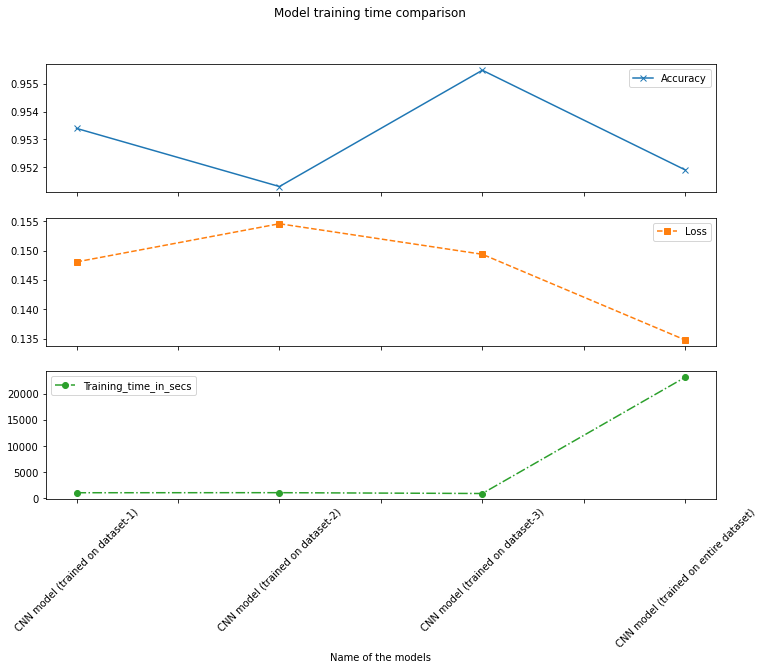

In [35]:
perform_compar_df.plot(style=['x-','s--', 'o-.'], title='Model training time comparison', figsize=(12, 8), xlabel='Name of the models', subplots = True, rot='45')

In [121]:
#evaluating the chosen models against other part-datasets
metrics_score_part1 = cnn_model_part4.evaluate(X_test_part1, y_test_part1, verbose=1)
metrics_score_part2 = cnn_model_part4.evaluate(X_test_part2, y_test_part2, verbose=1)
metrics_score_part3 = cnn_model_part4.evaluate(X_test_part3, y_test_part3, verbose=1)

20/20 [==============================] - 1s 56ms/step - loss: 0.1764 - accuracy: 0.9433


In [122]:
#printing the results

print(f'Test Loss: {round(metrics_score_part1[0], 4)} / Test Accuracy: {round(metrics_score_part1[1], 4)}')
print(f'Test Loss: {round(metrics_score_part2[0], 4)} / Test Accuracy: {round(metrics_score_part2[1], 4)}')
print(f'Test Loss: {round(metrics_score_part3[0], 4)} / Test Accuracy: {round(metrics_score_part3[1], 4)}')

Test Loss: 0.1846 / Test Accuracy: 0.9287
Test Loss: 0.2185 / Test Accuracy: 0.919
Test Loss: 0.1764 / Test Accuracy: 0.9433


# 6. Exporting the best model

In [123]:
#exporting the model file
model_file_name = 'model_CNN'
cnn_model_part4.save(model_file_name)

INFO:tensorflow:Assets written to: model_CNN\assets


In [124]:
#loading the model file
cnn_model = tf.keras.models.load_model(model_file_name, compile=True)

In [125]:
#getting predictions
y_pred_part1 = np.argmax(cnn_model.predict(X_train_part1), axis = 1)
y_pred_part2 = np.argmax(cnn_model.predict(X_train_part2), axis = 1)
y_pred_part3 = np.argmax(cnn_model.predict(X_train_part3), axis = 1)

In [126]:
##Confusion matrix
cnn_cf_part1 = confusion_matrix(y_train_part1, y_pred_part1)
cnn_cf_part2 = confusion_matrix(y_train_part2, y_pred_part2)
cnn_cf_part3 = confusion_matrix(y_train_part3, y_pred_part3)

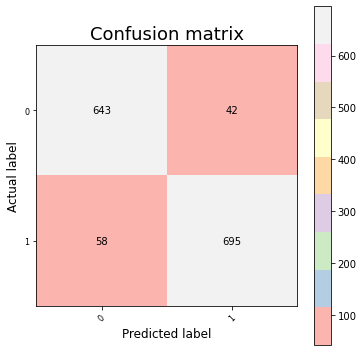

In [132]:
#plotting confusion matrix for the predictions against Dataset (part1)
plt.figure(figsize=(5,5))
plt.imshow(cnn_cf_part1, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 18)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0", "1"], rotation=45, size = 8)
plt.yticks(tick_marks, ["0", "1"], size = 8)
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cnn_cf_part1.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cnn_cf_part1[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

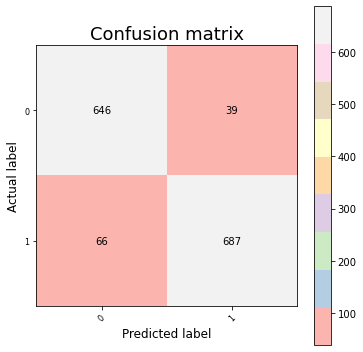

In [133]:
#plotting confusion matrix for the predictions against Dataset (part2)
plt.figure(figsize=(5,5))
plt.imshow(cnn_cf_part2, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 18)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0", "1"], rotation=45, size = 8)
plt.yticks(tick_marks, ["0", "1"], size = 8)
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cnn_cf_part2.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cnn_cf_part2[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

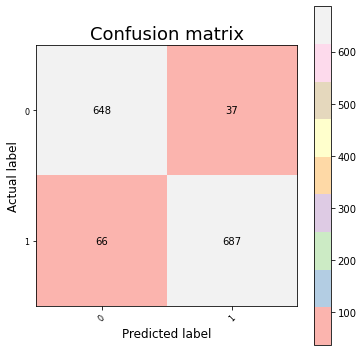

In [134]:
#plotting confusion matrix for the predictions against Dataset (part3)
plt.figure(figsize=(5,5))
plt.imshow(cnn_cf_part3, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 18)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["0", "1"], rotation=45, size = 8)
plt.yticks(tick_marks, ["0", "1"], size = 8)
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cnn_cf_part3.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cnn_cf_part3[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')